In [1]:
# Importation des librairies nécessaires

# Librairie traitements et graphiques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df=pd.read_csv("vin.csv",sep=";")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [3]:
df.isnull().sum().sum()

0

In [11]:
df.shape

(4898, 12)

In [6]:
X = df[df.columns[:-1]].values
y = df['quality'].values

In [10]:
X.shape

(4898, 11)

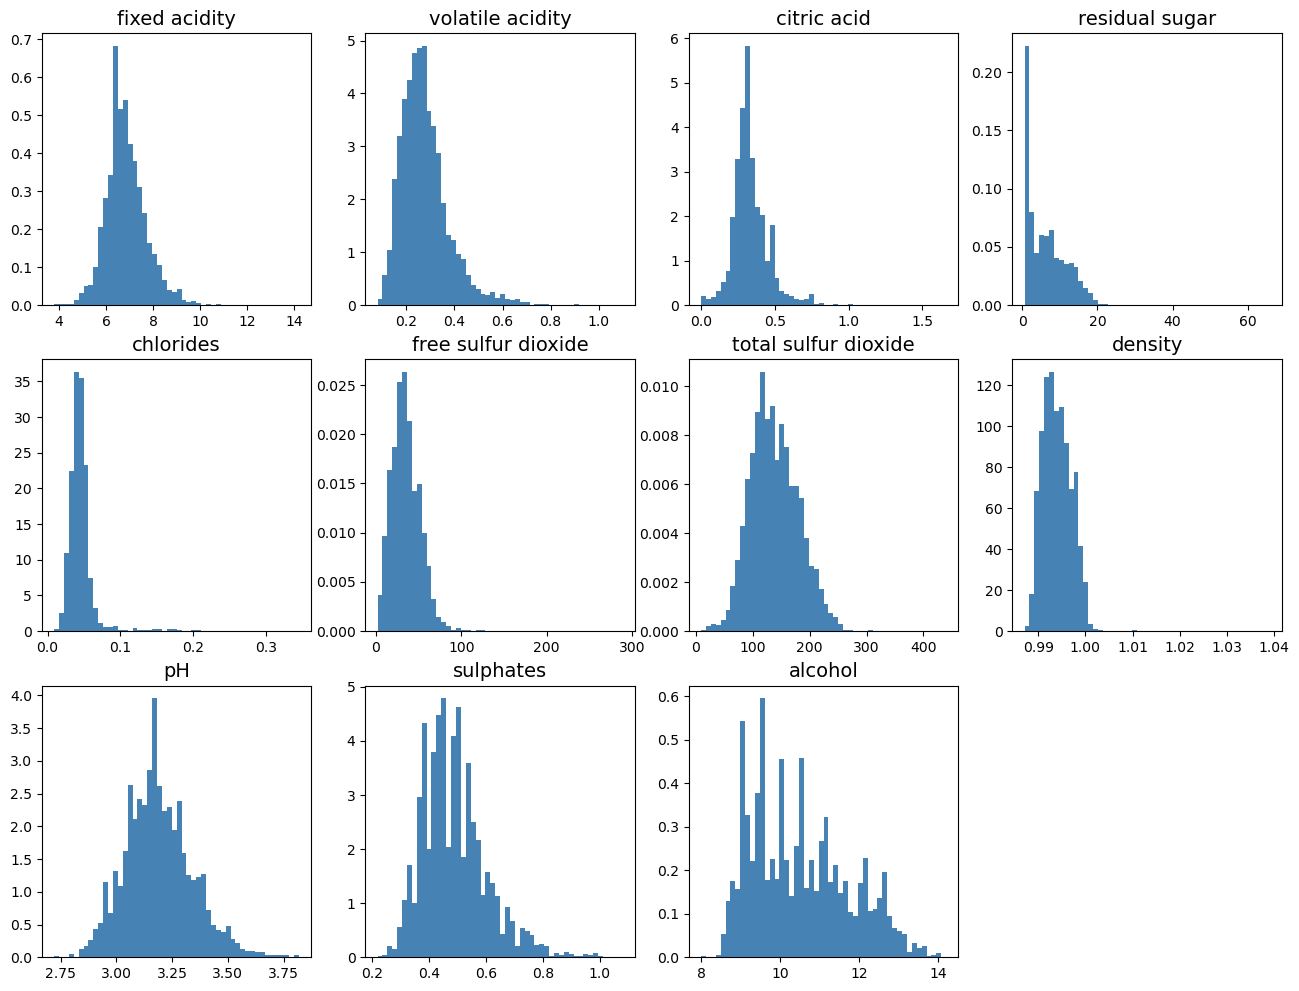

In [8]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(df.columns[feat_idx], fontsize=14)

In [12]:
y_class = np.where(y<6, 0, 1)

# 1. Classifieur avec KNN & CV

In [13]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y_class,
                                    test_size=0.3 # 30% des données dans le jeu de test
                                    )

In [14]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [15]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 9}
Résultats de la validation croisée :
accuracy = 0.762 (+/-0.017) for {'n_neighbors': 3}
accuracy = 0.768 (+/-0.015) for {'n_neighbors': 5}
accuracy = 0.770 (+/-0.021) for {'n_neighbors': 7}
accuracy = 0.774 (+/-0.017) for {'n_neighbors': 9}
accuracy = 0.771 (+/-0.018) for {'n_neighbors': 11}
accuracy = 0.772 (+/-0.016) for {'n_neighbors': 13}
accuracy = 0.772 (+/-0.023) for {'n_neighbors': 15}


In [16]:
y_pred = clf.predict(X_test_std)
print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))


Sur le jeu de test : 0.756


In [56]:
df_result = pd.DataFrame(clf.cv_results_['mean_test_score'],columns=["mean"])
df_knn = pd.DataFrame(param_grid)
df_result = pd.concat([df_result,df_knn],axis=1)
df_result

,mean,n_neighbors
0,0.761960,3
1,0.767506,5
2,0.769549,7
3,0.774213,9
4,0.771004,11
5,0.771879,13
6,0.772171,15


<AxesSubplot:title={'center':'Accuracy'}, xlabel='n_neighbors', ylabel='mean'>

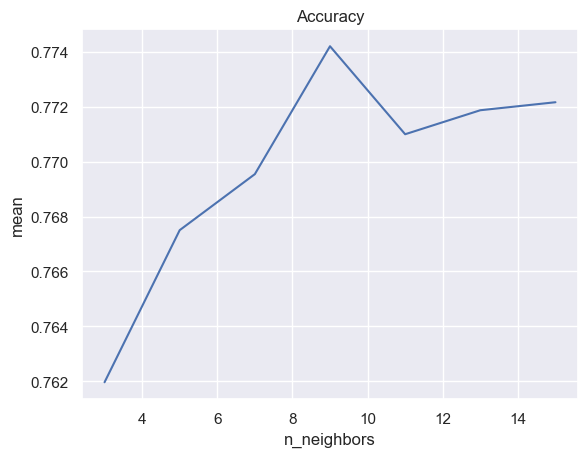

In [59]:
plt.title('Accuracy')
sns.set_theme(style="darkgrid")
sns.lineplot(data=df_result,x="n_neighbors", y="mean")